<a href="https://colab.research.google.com/github/EricKenjiLee/WaveMAP_Paper/blob/main/WaveMAP_Figures_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Download various data files by cloning the paper's Git repo.

---
*Note to reviewers: PLEASE DO NOT STAR OR FORK THE REPO WHICH IS DEANONYMIZING. The Github repository helps clone important files necessary for analysis.*

This git repository has various data files Which we clone below to allow you to run the google colab. There is no need to go to the original git repository the process of running this code leads to the files being downloaded and attached to this notebook.

In [ ]:
!git clone https://github.com/EricKenjiLee/WaveMAP_Paper.git

Cloning into 'WaveMAP_Paper'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 193 (delta 65), reused 160 (delta 40), pack-reused 0
Receiving objects: 100% (193/193), 2.50 MiB | 2.44 MiB/s, done.
Resolving deltas: 100% (65/65), done.


## Step 1a: Importing packages

We use the standard packages. The headache with python is that versions keep changing when the moon changes so we need to pin some versions for compatibility.

In [ ]:
# Importing packages 
# --- Importing matplotlib, seaborn, etc.

import os
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import io
import pickle as pkl
import h5py
import xml.etree.ElementTree as ET

These non-standard packages are pinned for compatibility reasons. 

In [ ]:
!pip install networkx==2.4
import networkx as nx

!pip install scikit-learn==0.22.2.post1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

!pip install xgboost==1.0.2
import xgboost as xgb

!pip install umap-learn==0.5.0
from umap import umap_ as umap

!pip install cylouvain==0.2.2
import cylouvain

!pip install shap==0.35
import shap

!pip install python-igraph==0.8.2
import igraph as ig

     |████████████████████████████████| 1.6MB 6.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5
     |████████████████████████████████| 109.8MB 102kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 81kB 4.2MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.0-cp37-none-any.whl size=76337 sha256=f4db69606adeb84445a7bcf361aa0b048e8989d1f9d174a99cd2386e6ee4f69a
  Stored in directory: /root/.cache/pip/wheels/c6/64/c4/6ff874f1bfedf37c36d1799b6f3da78c5bbcde007fbda096aa
Successfully built umap-learn
  Found existing installation: umap-learn 0.5.1
    Uninstalling umap-learn-0.5.1:
      Successfully uninstalled umap-learn-0.5.1
     |████████████████████████████████| 133kB 5.8M

#Step 2: Colormap selection for clusterings

---

The clusterings get clustered in a random order so although these colors reflect those used in the manuscript, they will likely need to be permuted to match what is found in our figures. Note the colors are just illustrative.

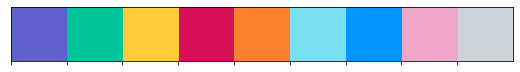

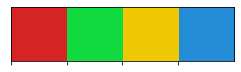

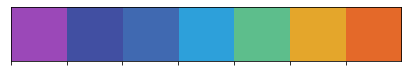

In [ ]:
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.60913030654, 0.2825991,	0.7235],
[0.25882122,	0.313636530368, 0.6353],
[0.2510008,	0.41183111216, 0.698],
[0.1764834,	0.63117918224, 0.8588],
[0.3685829,	0.749, 0.54905277224],
[0.898,	0.65483284296, 0.1686444],
[0.898,	0.4154841256, 0.1646932]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

# Step 3: Setting of parameters

---

This sets various defaults like sampling rate, u-probe depths, random state which is important for stochastic algorithms. Number of neighbors in the UMAP case, and the Louvain resolution parameter.

Changing the resolution parameter increases or decreases the number of clusters. 

In [ ]:
#These are the depths that the V-probe channels are located at
DEPTHS = [0.15,0.3,0.45,0.60,0.75,0.9,1.05,1.20,1.35,1.50,1.65,1.80,1.95,2.1,2.25,2.4]

#This converts time points to real time. There are 48 samples per waveform colleted at 30 kilosamples
SAMP_RATE_TO_TIME = 1/(48/30000) 

#Setting of random seed across Python kernel and packages to ensure reproducibility 
RAND_STATE=42
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

#UMAP Parameters
#The number of neighbors considered when constructing the high-d graph. 
#Made more global-information preserving by increasing it from 15 to 20.
N_NEIGHBORS = 20 

#The minimum distance between points in the projection.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.1

#Louvain Clustering Parameters
RESOLUTION = 1.5

# BLUE COLOR
BlueCol = '\033[94m'

# Step 4: Loading of processed waveform data

---

This cell loads varous files including the 250 Hz filtered waveforms, the gmm features, the BIC used for selecting number of GMM clusters.

In [ ]:
print(BlueCol + 'Loading data')

rel_path = os.getcwd()
fullDataPath = os.path.join(rel_path,'WaveMAP_Paper/data/full_data.npy');
GMMclasslabelpath = os.path.join(rel_path,
'WaveMAP_Paper/data/waveformsClassified_250hz_refiltered.mat')
GMMfeaturepath = os.path.join(rel_path,
'WaveMAP_Paper/data/gmm_features.mat')
BICpath = os.path.join(rel_path,
'WaveMAP_Paper/data/BIC_list.mat')
eightclassGMMpath = os.path.join(rel_path,'WaveMAP_Paper/data/8_class_GMM.mat');
filtfulldfPath = os.path.join(rel_path,'WaveMAP_Paper/data/filt_full_df.pkl');

print(rel_path)
print(fullDataPath);
print(GMMclasslabelpath)
print(GMMfeaturepath)
print(BICpath)
print(eightclassGMMpath)
print(filtfulldfPath)

full_data = np.load(fullDataPath)
allDataDFPath = os.path.join(rel_path,'WaveMAP_Paper/data/full_data_df.pkl');

GMM_class_labels = scipy.io.loadmat(GMMclasslabelpath)['classifies'].T
gmm_features_data = scipy.io.loadmat(GMMfeaturepath)['features']

GMM_class_labels = GMM_class_labels[~np.isnan(GMM_class_labels)]
GMM_class_df = pd.DataFrame(GMM_class_labels,columns=['Class'])
gmm_feat_data_nonan = gmm_features_data[~np.isnan(gmm_features_data)].reshape(len(GMM_class_df),3)

BIC_list = scipy.io.loadmat(BICpath)['BIC_list'][0]

eight_GMM_classes = scipy.io.loadmat(eightclassGMMpath)['classifies']

all_data_df = pkl.load(open(allDataDFPath,'rb'))
filt_full_df = pkl.load(open(filtfulldfPath,"rb"))

print(allDataDFPath)

Loading data
/content
/content/WaveMAP_Paper/data/full_data.npy
/content/WaveMAP_Paper/data/waveformsClassified_250hz_refiltered.mat
/content/WaveMAP_Paper/data/gmm_features.mat
/content/WaveMAP_Paper/data/BIC_list.mat
/content/WaveMAP_Paper/data/8_class_GMM.mat
/content/WaveMAP_Paper/data/filt_full_df.pkl
/content/WaveMAP_Paper/data/full_data_df.pkl


# Step 5: Loading of processed firing rate data.

---

Raw data is too large to be hosted and processed given the I/O speeds and file size therefore processed data is used here.

In [ ]:
def read_pkl(pkl_file_loc):
  return pkl.load(open(pkl_file_loc,'rb'))

FR_trace_loc = 'WaveMAP_Paper/data/FR_traces'
FR_traces = os.listdir(FR_trace_loc)

UMAP_FR_traces = [x for x in FR_traces if not x.startswith('GMM')]
GMM_FR_traces = [x for x in FR_traces if x.startswith('GMM')]

UMAP_traces_df = pd.DataFrame(columns = ['clust','PREF','NONPREF','PREF_UPPER_BOUND','PREF_LOWER_BOUND',
                        'NONPREF_UPPER_BOUND','NONPREF_LOWER_BOUND'])
GMM_traces_df = pd.DataFrame(columns = ['clust','PREF','NONPREF','PREF_UPPER_BOUND','PREF_LOWER_BOUND',
                        'NONPREF_UPPER_BOUND','NONPREF_LOWER_BOUND'])

for i in range(0,8):
  traces = sorted([x for x in UMAP_FR_traces if str(i) in x],key=len)
  trace_arr = []
  
  trace_arr.append(i)
  for trace in traces:
    if 'pref_'+str(i)+'.pkl' == trace:
      trace_arr.append(read_pkl(os.path.join(FR_trace_loc,trace)))
    elif 'nonpref_'+str(i)+'.pkl' == trace:
      trace_arr.append(read_pkl(os.path.join(FR_trace_loc,trace)))
    elif 'pref_bounds_'+str(i)+'.pkl' == trace:
      upper_bound, lower_bound = read_pkl(os.path.join(FR_trace_loc,trace))
      trace_arr.append(upper_bound)
      trace_arr.append(lower_bound)
    elif 'nonpref_bounds_'+str(i)+'.pkl' == trace:
      upper_bound, lower_bound = read_pkl(os.path.join(FR_trace_loc,trace))
      trace_arr.append(upper_bound)
      trace_arr.append(lower_bound)
  
  trace_series = pd.Series(trace_arr,index=UMAP_traces_df.columns)
  UMAP_traces_df = UMAP_traces_df.append(trace_series,ignore_index=True)

for i in range(1,5):
  traces = sorted([x for x in GMM_FR_traces if str(i) in x],key=len)
  trace_arr = []
  
  trace_arr.append(i)
  for trace in traces:
    if 'GMM_pref_'+str(i)+'.pkl' == trace:
      trace_arr.append(read_pkl(os.path.join(FR_trace_loc,trace)))
    elif 'GMM_nonpref_'+str(i)+'.pkl' == trace:
      trace_arr.append(read_pkl(os.path.join(FR_trace_loc,trace)))
    elif 'GMM_pref_bounds_'+str(i)+'.pkl' == trace:
      upper_bound, lower_bound = read_pkl(os.path.join(FR_trace_loc,trace))
      trace_arr.append(upper_bound)
      trace_arr.append(lower_bound)
    elif 'GMM_nonpref_bounds_'+str(i)+'.pkl' == trace:
      upper_bound, lower_bound = read_pkl(os.path.join(FR_trace_loc,trace))
      trace_arr.append(upper_bound)
      trace_arr.append(lower_bound)
  
  trace_series = pd.Series(trace_arr,index=GMM_traces_df.columns)
  GMM_traces_df = GMM_traces_df.append(trace_series,ignore_index=True)      

# Step 6: Loading of decision-related functional activity

In [ ]:
FR_stats_loc = 'WaveMAP_Paper/data/FR_stats'
decision_dynamics_loc = os.path.join(rel_path,'WaveMAP_Paper/data/decisionDynamics.mat');


baseline_FR_df = pkl.load(open(os.path.join(FR_stats_loc,'baseline_FR_df.pkl'),'rb'))
max_FR_df = pkl.load(open(os.path.join(FR_stats_loc,'max_FR_df.pkl'),'rb'))
GMM_baseline_FR_df = pkl.load(open(os.path.join(FR_stats_loc,'GMM_baseline_FR_df.pkl'),'rb'))
GMM_max_FR_df = pkl.load(open(os.path.join(FR_stats_loc,'GMM_max_FR_df.pkl'),'rb'))

dynamic_range_FR = np.subtract(max_FR_df['max_FR'],baseline_FR_df['baseline_FR'])
dynamic_range_FR_df = pd.DataFrame({'dynamic_range_FR': dynamic_range_FR, 
                                    'dbscan_color': baseline_FR_df['dbscan_color']})

with h5py.File(decision_dynamics_loc,"r") as f:
  diffV_list = []
  for i in range(8):
        diffV_list.append(np.array(f[f['forKenjiDat']['diffV'][i][0]]))

  coherences = []
  for i in range(7):
        coherences.append(f['metaData']['coherences'][0][i])

  dec_dyn_data = []
  dec_dyn_data_err = []
  
  for i in range(8):
      dec_dyn_data.append(np.array(f[f['forKenjiDat']['timeSlope'][i][0]]))
      dec_dyn_data_err.append(np.array(f[f['forKenjiDat']['timeSlopeE'][i][0]]))
  
  for i,x in enumerate(dec_dyn_data):
      dec_dyn_data[i] = [val for sublist in x for val in sublist]
      
  for i,x in enumerate(dec_dyn_data_err):
      dec_dyn_data_err[i] = [val for sublist in x for val in sublist]

      dec_dyn_slope = []
    
  for i in range(8):
      dec_dyn_slope.append(np.array(f[f['forKenjiDat']['slopeAsfCoh'][i][0]]))
  
  for i,x in enumerate(dec_dyn_slope):
      dec_dyn_slope[i] = [val for sublist in x for val in sublist]

discrim_data_path = 'WaveMAP_Paper/data/discrimination_times.pkl'
discrim_file = pkl.load(open(discrim_data_path,'rb'))

In [ ]:
masterArray = scipy.io.loadmat(os.path.join(rel_path,'WaveMAP_Paper/data/masterArray.mat'))['masterArray']

uprobeMask = scipy.io.loadmat(os.path.join(rel_path,'WaveMAP_Paper/data/uprobeMask.mat'))['uprobeMask']
uprobeMask = [i[0] for i in uprobeMask]

ch_depth = scipy.io.loadmat(os.path.join(rel_path,'WaveMAP_Paper/data/allChansUprobe.mat'))['allChansUprobe']
ch_depth = [i[0] for i in ch_depth]

# Figure 1E Bottom (Plots all the waveforms used in the analysis). 

The waveforms are normalized and plotted on top of each other with transparency.

### We plot all normalized single unit waveforms together

Plotting: 625 Waveforms


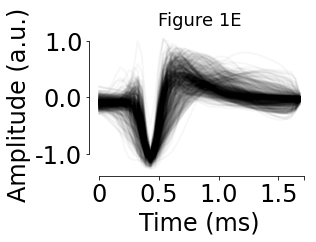

In [ ]:
# This plots all the normalized single unit waveforms together. The total waveform length is 48 points at 30000 samples/s
# 14, 28, 42 are the 0.5 ms, 1.0 ms, and 1.5 ms

# Generate subplots
f, arr = plt.subplots(1,figsize=[4.5,3.4])

print(BlueCol + "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i].T, c = 'k', alpha = 0.03,linewidth=2.);
    
arr.tick_params(direction='out',colors='k', axis='both')
    
# Set various x and y axes and labels etc.
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)

arr.spines['left'].set_bounds(-1,1)
arr.spines['bottom'].set_bounds(0,48)

arr.set_xlabel('Time (ms)', fontsize=24);
arr.set_xticks([0,14,28,42,48])
arr.set_xticklabels(['0','0.5','1.0','1.5',''],fontsize=24)

arr.set_ylabel('Amplitude (a.u.)', fontsize=24)
arr.set_yticks([-1.0,0.0,1.0]);
arr.set_yticklabels([-1.0,0.0,1.0], fontsize=24);

arr.set_title('Figure 1E', fontsize=18)

# Plot the data
plt.tight_layout()

# Figure 2 - Plots WaveMAP based clustering of waveforms using UMAP and Louvain Clustering.

## Figure 2A: Computation of WaveMAP clusters

### First we construct the high-dimensional graph with UMAP

In [ ]:
# This is the main lifting function. Note the important hyper parameters are N_NEIGHBORS, and RAND_STATE
# We show that the random seed has minimal effect in one of the later plots. 

reducer = umap.UMAP(n_neighbors = N_NEIGHBORS, min_dist=MIN_DIST, 
                    random_state=RAND_STATE)
mapper = reducer.fit(full_data)
embedding = reducer.transform(full_data)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(full_data)

### Next we apply Louvain clustering to the high-dimensional UMAP graph

In [ ]:
# This is an important step. We don't cluster on 2D projections instead it is performed on the high-dimensional graph

G = nx.from_scipy_sparse_matrix(mapper.graph_)
clustering = cylouvain.best_partition(G, resolution = RESOLUTION)
clustering_solution = list(clustering.values())
umap_df['color'] = clustering_solution

cluster_colors = [CUSTOM_PAL_SORT_3[i] for i in clustering_solution]

### This yields our UMAP graph colored by Louvain cluster

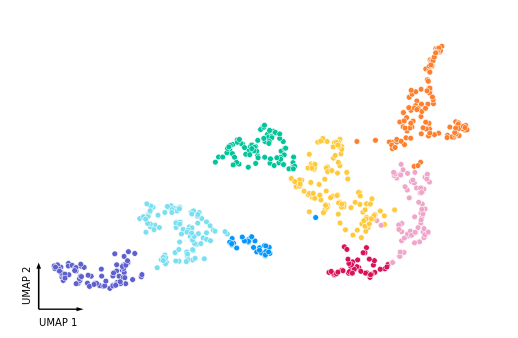

In [ ]:
# And now we have the beautiful plot generated by UMAP + Louvain Clustering
f,arr = plt.subplots(1,figsize=[7,4.5],tight_layout = {'pad': 0});
f.tight_layout()
arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
            marker='o', c=cluster_colors, s=32, edgecolor='w',
            linewidth=0.5)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xticks([]);
arr.set_yticks([]);
arr.set_xlim(-4,12)
arr.set_ylim(0,12)

arr.arrow(-3,0.8,0,1.5, width=0.05, shape="full", ec="none", fc="black")
arr.arrow(-3,0.8,1.2,0, width=0.05, shape="full", ec="none", fc="black")

arr.text(-3,0.3,"UMAP 1", va="center")
arr.text(-3.5,1.0,"UMAP 2",rotation=90, ha="left", va="bottom")

N_CLUST = len(set(clustering_solution))

In [ ]:
# Define a nice function that plots all the waveforms in long column.
def plot_group(label_ix, labels, groups_df, colors, mean_only=False, detailed=False):
    group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
    group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()
    
    f, arr = plt.subplots()
    f.set_figheight(1.8*0.65)
    f.set_figwidth(3.0*0.65)
    if not mean_only:
        for i,_ in enumerate(group_waveforms):
            plt.plot(group_waveforms[i],c=colors[label_ix-1],alpha=0.3,linewidth=1.5)
    
    if not mean_only:
        plt.plot(np.mean(group_waveforms,axis=0),c='k',linestyle='-')
    else:
        plt.plot(np.mean(group_waveforms,axis=0),c=colors[label_ix-1],linestyle='-')

    arr.spines['right'].set_visible(False)
    arr.spines['top'].set_visible(False)

    if detailed:
        
        avg_peak = np.mean([np.argmax(x) for x in group_waveforms[14:]])
        arr.axvline(avg_peak,color='k',zorder=0)
        
        arr.set_ylim([-1.3,1.3])
        arr.set_yticks([])
        arr.set_xticks([0,7,14,21,28,35,42,48])
        arr.tick_params(axis='both', which='major', labelsize=12)
        arr.set_xticklabels([0,'',0.5,'',1.0,'',1.5,''])
        arr.spines['left'].set_visible(False)
        arr.grid(False)
        arr.set_xlim([0,48])

    if not detailed:
        arr.set(xticks=[],yticks=[])

        if not mean_only:
            x,y = 2.1,0.7
            ellipse = mpl.patches.Ellipse((x,y), width=9.0, height=0.72, facecolor='w',
                                 edgecolor='k',linewidth=1.5)
            label = arr.annotate(str(label_ix), xy=(x-0.25, y-0.15),fontsize=12, color = 'k', ha="center")
            arr.add_patch(ellipse)

            if i != -1:
                x, y = 23,-0.7
                n_waveforms = plt.text(x, y, 
                                       'n = '+str(len(group_waveforms))+
                                       ' ('+str(round(len(group_waveforms)/len(groups_df)*100,2))+'%)'
                                       , fontsize=10)
    
    return f, arr

### Lastly we plot the waveforms for each cluster together along with their average waveform

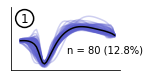

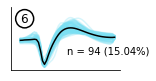

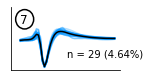

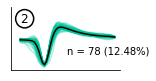

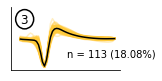

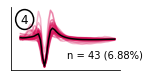

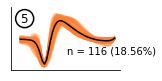

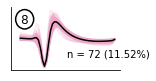

In [ ]:
# Note the BSclass and NSclass might change depending on your random number generation system. It does not really matter and is separated here only for didactic
# purposes
BSclass = [1, 6, 7]
NSclass = [2, 3, 4, 5, 8]
for i in BSclass:
    plot_group(i,clustering_solution,umap_df,CUSTOM_PAL_SORT_3)

for i in NSclass:
    plot_group(i,clustering_solution,umap_df,CUSTOM_PAL_SORT_3)


## Figure 2B: Optimizing number of Louvain clusters

This goes through resolution parameters from 0 to 10 in steps of 0.5

### We calculate the modularity score and number of Louvain clusters across a range of resolution parameters while randomly permuting the waveform order. 

---

**THIS CELL CAN TAKE 20 MIN**; skip it and run the next cell to read cached values of the plot.


In [ ]:
resolution_list = np.linspace(0,10,21)
modularity_dict = {}
n_clusts_dict = {}

subsets=[100]

for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = N_NEIGHBORS, 
                                     min_dist=MIN_DIST, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            G = nx.from_scipy_sparse_matrix(mapper.graph_)
            clustering = cylouvain.best_partition(G, resolution = res)
            modularity = cylouvain.modularity(clustering, G)
            clustering_solution = list(clustering.values())
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


0.0


KeyboardInterrupt: ignored

### And plot both on the same axis



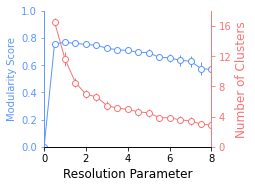

In [ ]:
resolution_list = np.linspace(0,10,21)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

## Figure 2C: Classifier performance on clustering

### First we create a 70/30 test-train split of the data

In [ ]:
testSize = 0.3;

UMAP_X = np.stack(umap_df['waveform'].to_numpy().tolist(), axis=0)
UMAP_y = umap_df['color'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)

### Next we use XGBoost to train a hyperparameter optimized random forest classifier on the WaveMAP clusters

In [ ]:
numCV = 5

UMAP_model = xgb.XGBClassifier()
UMAP_param_dist = {"max_depth": [4],
              "min_child_weight" : [2.5],
              "n_estimators": [100],
              "learning_rate": [0.3],
              "seed": [RAND_STATE]}
UMAP_grid_search = GridSearchCV(UMAP_model, param_grid=UMAP_param_dist, 
                           cv = numCV, 
                           verbose=10, n_jobs=-1)
UMAP_grid_search.fit(UMAP_X_train, UMAP_y_train)

confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


array([[22,  0,  0,  0,  0,  1,  0,  0],
       [ 0, 26,  3,  0,  1,  0,  0,  0],
       [ 0,  0, 28,  1,  0,  0,  0,  0],
       [ 0,  0,  1, 18,  0,  0,  0,  0],
       [ 0,  0,  1,  0, 28,  0,  0,  0],
       [ 1,  0,  0,  0,  2, 24,  1,  0],
       [ 0,  0,  1,  2,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 19]])

### Lastly we plot a confusion matrix for the test accuracy of the classifier

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


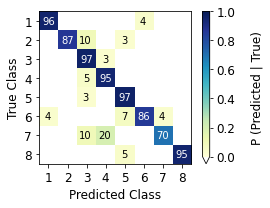

In [ ]:
confusion_mat_counts = confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test))

conf_mat_row_list = []

for row in confusion_mat_counts:
    row_sum = np.sum(row)
    
    row_percent = []
    
    for val in row:
        row_percent.append(val/row_sum)
    
    conf_mat_row_list.append(row_percent)

conf_mat = np.array(conf_mat_row_list)

colormap = mpl.cm.YlGnBu
colormap.set_under('white')

eps = np.spacing(0.0)
f, arr = plt.subplots(1,figsize=[4,3])
mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
color_bar = f.colorbar(mappable, ax=arr, extend='min')
color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15,fontname="Arial")
color_bar.ax.tick_params(size=3,labelsize=12)

#Specify label behavior of the main diagonal
for i in range(0,N_CLUST):
    if int(conf_mat[i,i]*100) == 100:
        arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
    else:
        arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
        
#Specify label behavior of the off-diagonals
for i in range(0,N_CLUST):
    for j in range(0,N_CLUST):
        if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
            arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")
        elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.5 and conf_mat[i,j] != 0:
            arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")

arr.set_xticks(range(0,N_CLUST))
arr.set_xticklabels(range(1,N_CLUST+1),fontsize=12);
arr.set_yticks(range(0,N_CLUST))
arr.set_yticklabels(range(1,N_CLUST+1),fontsize=12);
arr.set_xlabel('Predicted Class',fontsize=12);
arr.set_ylabel('True Class',fontsize=12);
plt.tight_layout()

# Figure 3: Evaluates the solutions obtained from GMM clustering and shows that it is much poorer than the ones obtained by WAVEMAP



## Figure 3B: GMM clustering in a 3-D feature space

### We first set up a pandas dataframe with the specified feature values

In [ ]:
UMAP_and_GMM = pd.concat([umap_df,pd.DataFrame(gmm_feat_data_nonan,columns=['troughToPeak','prePostHyper','FWHM1'])],axis=1)
UMAP_and_GMM['dbscan_hex'] = cluster_colors
UMAP_and_GMM['gmm_labels'] = GMM_class_labels

UMAP_and_GMM['troughToPeak_abs'] = UMAP_and_GMM['troughToPeak'].divide(SAMP_RATE_TO_TIME)
UMAP_and_GMM['FWHM1_abs'] = UMAP_and_GMM['FWHM1'].divide(SAMP_RATE_TO_TIME)

### and then plot the points in this space by cluster identity (clustering done in MATLAB).

(0.0, 0.6)

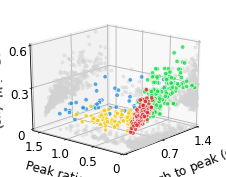

In [ ]:
fig = plt.figure(figsize=[3.8,3])
ax = fig.add_subplot(111, projection='3d')

for i in [int(x) for x in np.unique(UMAP_and_GMM['gmm_labels'])]:
    to_plot_df = UMAP_and_GMM[UMAP_and_GMM['gmm_labels'] == i]
    x = to_plot_df['troughToPeak_abs']
    y = to_plot_df['prePostHyper']
    z = to_plot_df['FWHM1_abs']
    ax.scatter(x,y,z,c=GMM_PAL[i-1],marker='o',alpha=0.75,s=20,linewidth=0.75,edgecolor='w',depthshade=True)
    
    ax.plot(x, z, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='y', zs=1.6)
    ax.plot(y, z, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='x', zs=1.4)
    ax.plot(x, y, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='z', zs=0.)

ax.tick_params(pad=-1)

ax.set_xlabel('Trough to peak ($\mu$s)',fontsize=12,labelpad=5)
ax.set_ylabel('Peak ratio',fontsize=12,labelpad=5)
ax.set_zlabel('AP width ($\mu$s)',fontsize=12,labelpad=0)
ax.view_init(elev=20, azim=220)

ax.set_xticks([0,0.7,1.4])
ax.set_xticklabels(['',0.7,1.4],fontsize=12)
ax.set_yticks([0,0.5,1,1.5])
ax.set_yticklabels([0,0.5,1.0,1.5],fontsize=12)
ax.set_zticks([0,0.3,0.6])
ax.set_zticklabels([0,0.3,0.6],fontsize=12)

ax.set_xlim([0,1.4])
ax.set_ylim([0,1.6])
ax.set_zlim([0.,0.6])

## Figure 3C: Optimal GMM cluster number

### We use Bayesian information criterion to calculate the 'elbow' in a BIC vs. cluster number

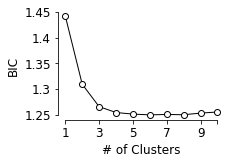

In [ ]:
f, arr = plt.subplots()
f.set_size_inches(3., 2.)

arr.plot(BIC_list,c='k',
            marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)

arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xlabel('# of Clusters', fontsize=12)
arr.set_xticks([0,2,4,6,8,9])
arr.set_xticklabels([1,3,5,7,9,''],fontsize=12)
arr.set_ylabel('BIC', fontsize=12)
arr.set_yticks([12500,13000,13500,14000,14500])
arr.set_yticklabels(['1.25','1.3','1.35','1.4','1.45'],fontsize=12)
arr.spines['left'].set_bounds(12500,14500)
arr.spines['bottom'].set_bounds(0,9)

## Figure 3D: Classifier trained on GMM classes

### Now we train a random forest classifier on the GMM classes

In [ ]:
X = np.stack(UMAP_and_GMM['waveform'].to_numpy().tolist(), axis=0)
y = UMAP_and_GMM['gmm_labels'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(y) if clust == -1]

X = np.delete(X,unclassified_ixs,axis=0)
y = np.delete(y,unclassified_ixs,axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RAND_STATE)

data_dmatrix = xgb.DMatrix(data=X,label=y)

### and show a confusion matrix of the five-fold cross-validated test accuracy

In [ ]:
model = xgb.XGBClassifier()
param_dist = {"max_depth": [10],
              "min_child_weight" : [2.5],
              "n_estimators": [110],
              "learning_rate": [0.05],
              "seed": [RAND_STATE]}
grid_search = GridSearchCV(model, param_grid=param_dist, 
                           cv = 5, 
                           verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

confusion_matrix(y_test,grid_search.predict(X_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


array([[65,  4,  1,  0],
       [10, 57,  0,  1],
       [ 5,  0, 28,  1],
       [ 0,  2,  5,  9]])

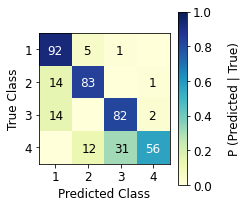

In [ ]:
confusion_mat_counts = confusion_matrix(y_test,grid_search.predict(X_test))

conf_mat_row_list = []

for row in confusion_mat_counts:
    row_sum = np.sum(row)
    row_percent = []
    
    for val in row:
        row_percent.append(val/row_sum)
    
    conf_mat_row_list.append(row_percent)

conf_mat = np.array(conf_mat_row_list)
colormap = mpl.cm.YlGnBu
colormap.set_under('white')

f, arr = plt.subplots()
f.set_size_inches(3, 3)
plt.tight_layout()
mappable = arr.imshow(conf_mat,cmap=colormap,vmin=0.,vmax=1.)
color_bar = f.colorbar(mappable, ax=arr)
color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15)
color_bar.ax.tick_params(size=3,labelsize=12)
arr.set_xticks([0,1,2,3])
arr.set_xticklabels([1,2,3,4],fontsize=12);
arr.set_yticks([0,1,2,3])
arr.set_yticklabels([1,2,3,4],fontsize=12);
arr.set_xlabel('Predicted Class',fontsize=12)
arr.set_ylabel('True Class',fontsize=12)

for i in range(0,4):
    if int(conf_mat[i,i]*100) == 100:
        arr.text(i-0.35,i+0.15,int(conf_mat[i,i]*100),fontsize=12,c='white')
    else:
        arr.text(i-0.25,i+0.15,int(conf_mat[i,i]*100),fontsize=12,c='white')
        
for i in range(0,4):
    for j in range(0,4):
        if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
            arr.text(j-0.15,i+0.15,int(conf_mat[i,j]*100),fontsize=12,c='k')
        elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] <= 0.5:
            arr.text(j-0.2,i+0.15,int(conf_mat[i,j]*100),fontsize=12,c='k')

## Figure 3E: GMM labels in UMAP space

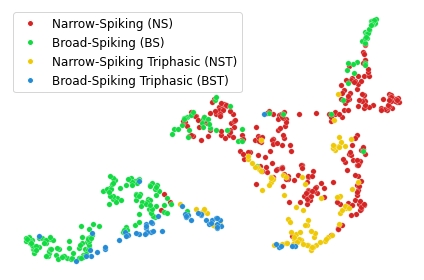

In [ ]:
GMM_class_labels = GMM_class_labels[~np.isnan(GMM_class_labels)]
GMM_class_df = pd.DataFrame(GMM_class_labels,columns=['Class'])

full_data_df = pd.DataFrame({'Waveform': full_data.tolist()})
data_classified_df = pd.concat([umap_df,full_data_df,GMM_class_df],axis=1)

f, arr = plt.subplots()

class_labels = [x for x in np.unique(data_classified_df['Class']) if str(x) != 'nan']

for ix in np.unique(class_labels):
    filt_df = data_classified_df[data_classified_df['Class']==ix]
    arr.scatter(filt_df['x'],filt_df['y'], s=30,marker='o', linewidth=0.25, 
                edgecolors='white', alpha=1, c=GMM_PAL[int(ix-1)])

ns = Line2D(xdata=[], ydata=[], marker='o', markerfacecolor=GMM_PAL[0], 
                color='w', label='Narrow-Spiking (NS)')
bs = Line2D(xdata=[], ydata=[], marker='o', markerfacecolor=GMM_PAL[1], 
                      color='w', label='Broad-Spiking (BS)')
nst = Line2D(xdata=[], ydata=[], marker='o', markerfacecolor=GMM_PAL[2], 
                      color='w', label='Narrow-Spiking Triphasic (NST)')
bst = Line2D(xdata=[], ydata=[], marker='o', markerfacecolor=GMM_PAL[3], 
                      color='w', label='Broad-Spiking Triphasic (BST)')

arr.legend(handles=[ns,bs,nst,bst],fontsize=12)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xticks([]);
arr.set_yticks([]);
plt.tight_layout()
f.set_size_inches(6, 4)

### Here we also show all the single units per GMM cluster with the averaged waveform in black

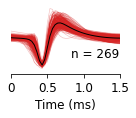

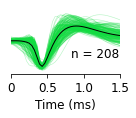

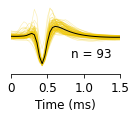

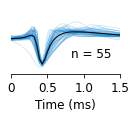

In [ ]:
for i in np.unique(GMM_class_labels):
    f, arr = plt.subplots()
    f.set_size_inches(2, 1.75)
    GMM_cluster = data_classified_df[data_classified_df['Class']==i]
    
    for _,row in GMM_cluster.iterrows():
        plt.plot(row['Waveform'],alpha=.3,linewidth=.6,c=GMM_PAL[int(i-1)])
        
    plt.plot(np.nanmean(GMM_cluster['Waveform'].tolist(),axis=0),c='k',linewidth=1.)

    arr.spines['right'].set_visible(False)
    arr.spines['top'].set_visible(False)
    arr.set_ylim([-1.4,1.1])
    arr.set_xticks([0,14,28,42])
    arr.set_xticklabels(['0','0.5','1.0','1.5'])
    arr.set_xlabel('Time (ms)',fontsize=12)
    arr.set_xlim([0,42])
    arr.set_yticks([])
    arr.tick_params(axis='both', which='major', labelsize=12)
    
    arr.spines['left'].set_visible(False)
    
    x, y = 23,-0.8

    n_waveforms = plt.text(x, y, 'n = '+str(len(GMM_cluster))
                       , fontsize=12)
    plt.tight_layout()
    plt.margins(0,0)

# Figure 4: Interpretable Machine Learning on WaveMAP

## Figure 4A: Inverse mapping of WaveMAP

### We use UMAP's inverse transform function to produce waveforms found on a grid of test points tiling the manifold

---

Note that this *is* sensitive to the stochasticity in projection and likely will look incorrectly aligned to the grid. This is because the projection of the high-dimensional graph uses a force directed layout algorithm using stochastic gradient descent. Although the stochastic gradient descent can be made deterministic through setting a seed, the seed will vary at the level of the CPU OS itself and cannot be set from within Colab. Since Colab spins up a new instance every session, this can look different day-to-day if you let your session expire. You can change the location of the corners of the grid in the `corners` variable to try to produce a good fit.

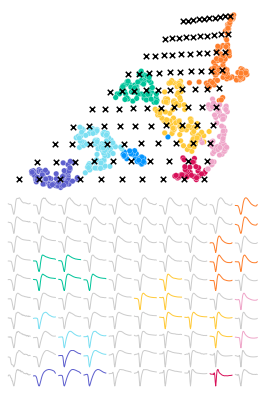

In [ ]:
def find_nearest_color(embedding, test_coord, threshold_dist=0.3):
    x_array, y_array = embedding[:,0], embedding[:,1]
    
    # Take coordinates of test point to calculate an array of each point's distance to test then return index
    # where the minimum value is found
    dist_array = np.array(np.abs(x_array-test_coord[0])+np.abs(y_array-test_coord[1]))
    idx = dist_array.argmin()
    
    if dist_array[idx] <= threshold_dist:
        return cluster_colors[idx]
    
    else:
        return (0.8,0.8,0.8)


corners = np.array([
    [6.7, 10.2],  # top-left
    [9.6, 10.5],  # top-right
    [-3.3, 2.],  # bottom-left
    [8, 2],  # bottom-right
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

inv_transformed_points = reducer.inverse_transform(test_pts)

# Set up the grid
fig = plt.figure(figsize=(4.5,7))
gs = GridSpec(20, 10, fig)
gs.update(wspace=0.05, hspace=0.05)
scatter_ax = fig.add_subplot(gs[:10, :10])
waveform_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        waveform_axes[i, j] = fig.add_subplot(gs[10+ i,j])

scatter_ax.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1],
                c=cluster_colors, s=30,linewidth=0.25,edgecolor='white',zorder=1)
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', 
                   c='k',
                   s=30, zorder=2, alpha=1)

# Plot each of the generated waveforms
for i in range(10):
    for j in range(10):
        waveform_axes[i, j].plot(inv_transformed_points[i*10 + j], 
                                     c = find_nearest_color(reducer.embedding_,
                                                            test_pts[i*10 + j]),
                                linewidth=1.0)
            
        waveform_axes[i, j].set(xticks=[], yticks=[])
        waveform_axes[i, j].spines['right'].set_visible(False)
        waveform_axes[i, j].spines['top'].set_visible(False)
        waveform_axes[i, j].spines['left'].set_visible(False)
        waveform_axes[i, j].spines['bottom'].set_visible(False)
        
scatter_ax.set(xticks=[], yticks=[])
scatter_ax.spines['right'].set_visible(False)
scatter_ax.spines['top'].set_visible(False)
scatter_ax.spines['left'].set_visible(False)
scatter_ax.spines['bottom'].set_visible(False)

## Figure 4B: SHAP Values

### First we plot the SHAP values at the top-10 time points broken down by their "informativeness" per waveform cluster

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


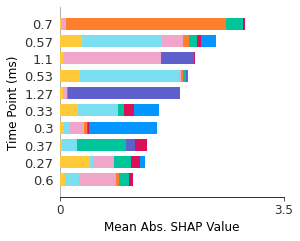

In [ ]:
n_bars = 10
X = np.stack(UMAP_and_GMM['waveform'].to_numpy().tolist(), axis=0)
y = UMAP_and_GMM['gmm_labels'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(y) if clust == -1]

X = np.delete(X,unclassified_ixs,axis=0)
y = np.delete(y,unclassified_ixs,axis=0)

UMAP_model = xgb.XGBClassifier(UMAP_grid_search.best_params_)
UMAP_model.fit(UMAP_X_train,UMAP_y_train)
explainer = shap.TreeExplainer(UMAP_model)
 
shap_values = explainer.shap_values(X)

clust_colors = []
SHAP_REORDERING = [2,5,7,4,1,0,3,6] #Need to do this so the UMAP colormap aligns with the SHAP color order
for i in SHAP_REORDERING:
    clust_colors.append(UMAP_and_GMM[UMAP_and_GMM['color']==i]['dbscan_hex'].iloc[0])

umap_cmap = mpl.colors.ListedColormap(clust_colors, name='umap_cmap')

fig = plt.figure();

shap.summary_plot(shap_values[:], X, [str(np.round(x*(1/30000)*1000,2)) for x in pd.DataFrame(X).columns.tolist()],
                  plot_type='bar',show=False,color=umap_cmap,
                  max_display = n_bars)

ax = fig.gca();
ax.set_xlabel('Mean Abs. SHAP Value',size=12,fontname='Arial')
ax.set_ylabel('Time Point (ms)',size=12,fontname='Arial')
ax.get_legend().remove()
ax.set_xlim([0,3.5])
ax.set_xticks([0.0,3.5])
ax.set_xticklabels([0,3.5],fontsize=12,fontname='Arial')
fig.set_size_inches(4,3.5);

ytick_labels = [round(np.float(i.get_text())/(1000/30000)) for i in ax.get_yticklabels()][::-1]
bar_heights = []

for j in range(n_bars):

    bar_height = ax.patches[j].get_width()
    bar_heights.append(bar_height)

bar_heights = bar_heights[::-1]
percent_total_height = [x/sum(bar_heights) for x in bar_heights]
for k,label in enumerate(ytick_labels):
    arr.axvline(label,color='k',alpha=percent_total_height[k])

### And show where these time points are located

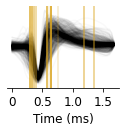

In [ ]:
f, arr = plt.subplots(1,figsize=[2,1.5])

for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i].T, c = 'k', alpha = 0.025,linewidth=1.5);
    
arr.tick_params(direction='out',colors='k', axis='both')
    
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['left'].set_visible(False)

arr.set_xlabel('Time (ms)', fontsize=12,fontname='Arial');
arr.set_xticks([0,14,28,42])
arr.set_xticklabels(['0','0.5','1.0','1.5'],fontsize=12,fontname='Arial')

arr.set_yticks([]);

for i,t in enumerate(ytick_labels):
    arr.axvline(t,alpha=percent_total_height[i]*20,
                color='goldenrod',lw=2)

## Figure 4C: SHAP values broken down by WaveMAP cluster

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


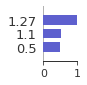

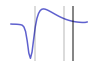

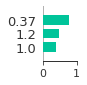

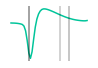

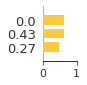

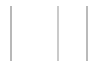

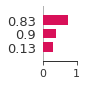

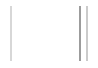

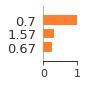

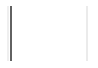

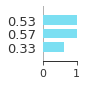

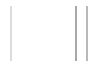

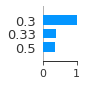

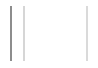

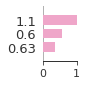

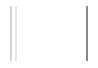

In [ ]:
n_bars = 3
for i in range(len(shap_values)):
    fig = plt.figure()
    
    clust_color = UMAP_and_GMM[UMAP_and_GMM['color']==i]['dbscan_hex'].iloc[0]
    shap.summary_plot(shap_values[i], X, 
                      [str(np.round(x*(1000/30000),2)) for x in pd.DataFrame(X).columns.tolist()],
                      plot_type="bar", 
                      max_display = n_bars, color = clust_color,show=False)
    ytick_labels = [np.float(i.get_text())*0.05 for i in ax.get_yticklabels()][::-1]
    
    ax = fig.gca()
    fig.set_size_inches(0.6,1.0)
    ax.set_xlabel('',fontsize=12)
    ax.set_ylabel('',fontsize=12)
    ax.set_xlim(0,1)

    f, arr = plot_group(i+1,clustering_solution,UMAP_and_GMM,CUSTOM_PAL_SORT_3,mean_only=True)
    ytick_labels = [round(np.float(i.get_text())/(1000/30000)) for i in ax.get_yticklabels()][::-1]
    bar_heights = []
    arr.spines['left'].set_visible(False)
    arr.spines['right'].set_visible(False)
    arr.spines['bottom'].set_visible(False)

    for j in range(n_bars):

        bar_height = ax.patches[j].get_width()
        bar_heights.append(bar_height)

    bar_heights = bar_heights[::-1]
    percent_total_height = [x/sum(bar_heights) for x in bar_heights]
    for k,label in enumerate(ytick_labels):
        arr.axvline(label,color='k',alpha=percent_total_height[k])
    f.set_size_inches([1.5,1.0])

# Figure 5

## Figure 5A,B: Average FR traces aligned to stimulus

### We plot the FR traces aligned to stimulus onset

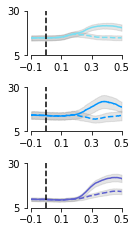

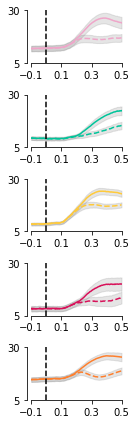

In [ ]:
BS_ORDERING = [5,6,0]
NS_ORDERING = [7,1,2,3,4]

f, arr = plt.subplots(3,figsize=[2,3.33])

time = np.arange(-0.1,0.5,0.001)

for i,ix in enumerate(BS_ORDERING):
  PREF = UMAP_traces_df.iloc[ix]['PREF']
  NONPREF = UMAP_traces_df.iloc[ix]['NONPREF']
  PREF_UPPER = UMAP_traces_df.iloc[ix]['PREF_UPPER_BOUND']
  PREF_LOWER = UMAP_traces_df.iloc[ix]['PREF_LOWER_BOUND']
  NONPREF_UPPER = UMAP_traces_df.iloc[ix]['NONPREF_UPPER_BOUND']
  NONPREF_LOWER = UMAP_traces_df.iloc[ix]['NONPREF_LOWER_BOUND']
  arr[i].plot(time,PREF,color=CUSTOM_PAL_SORT_3[ix])
  arr[i].plot(time,NONPREF,'--',color=CUSTOM_PAL_SORT_3[ix])
  arr[i].fill_between(time,PREF_UPPER,PREF_LOWER,
            color='gray',alpha=0.2)
  arr[i].fill_between(time,NONPREF_UPPER,NONPREF_LOWER,
            color='gray',alpha=0.2)
  arr[i].set_ylim(5,30)
  arr[i].set_xticks([-0.1,0.1,0.3,0.5])
  arr[i].set_xlim(-0.1,0.5)
  arr[i].set_yticks([5,30])
  arr[i].spines['left'].set_position(('axes', -0.05))
  arr[i].spines['top'].set_visible(False)
  arr[i].spines['right'].set_visible(False)
  arr[i].axvline(0,ymin=0.,ymax=30,linestyle='dashed',color='k')
  f.tight_layout()

f, arr = plt.subplots(5,figsize=[2,6])

time = np.arange(-0.1,0.5,0.001)

for i,ix in enumerate(NS_ORDERING):
  PREF = UMAP_traces_df.iloc[ix]['PREF']
  NONPREF = UMAP_traces_df.iloc[ix]['NONPREF']
  PREF_UPPER = UMAP_traces_df.iloc[ix]['PREF_UPPER_BOUND']
  PREF_LOWER = UMAP_traces_df.iloc[ix]['PREF_LOWER_BOUND']
  NONPREF_UPPER = UMAP_traces_df.iloc[ix]['NONPREF_UPPER_BOUND']
  NONPREF_LOWER = UMAP_traces_df.iloc[ix]['NONPREF_LOWER_BOUND']
  arr[i].plot(time,PREF,color=CUSTOM_PAL_SORT_3[ix])
  arr[i].plot(time,NONPREF,'--',color=CUSTOM_PAL_SORT_3[ix])
  arr[i].fill_between(time,PREF_UPPER,PREF_LOWER,
            color='gray',alpha=0.2)
  arr[i].fill_between(time,NONPREF_UPPER,NONPREF_LOWER,
            color='gray',alpha=0.2)
  arr[i].set_ylim(5,30)
  arr[i].set_xticks([-0.1,0.1,0.3,0.5])
  arr[i].set_xlim(-0.1,0.5)
  arr[i].set_yticks([5,30])
  arr[i].spines['left'].set_position(('axes', -0.05))
  arr[i].spines['top'].set_visible(False)
  arr[i].spines['right'].set_visible(False)
  arr[i].axvline(0,ymin=0.,ymax=30,linestyle='dashed',color='k')
  f.tight_layout()

## Figure 5C: Baseline WaveMAP cluster FRs

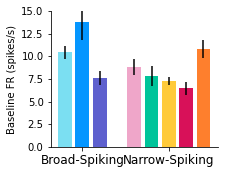

In [ ]:
def bootstrap_median(data,iter_=5000):
    median_list = []
    
    for i in range(iter_):
        median_list.append(np.median(np.random.choice(data,len(data))))
                
    return np.mean(median_list), np.std(median_list)

def get_baseline_FR_stats(df,clust_ix,conf=0.95,UMAP_clusts=True):
    baseline_FR = baseline_FR_df[baseline_FR_df['dbscan_color']==str(clust_ix)]['baseline_FR'].tolist()
    
    if not UMAP_clusts:
        GMM_baseline_FR = GMM_baseline_FR_df[GMM_baseline_FR_df['GMM_class']==str(clust_ix)]['baseline_FR'].tolist()
        
    n = len(baseline_FR)
    m, se = np.median(baseline_FR), scipy.stats.sem(baseline_FR)
    h = se * scipy.stats.t.ppf((1 + conf) / 2., n-1)
    return m, se, m-h, m+h

def get_baseline_FR(df,clust_ix,UMAP_clusts=True):
    baseline_FR = baseline_FR_df[baseline_FR_df['dbscan_color']==str(clust_ix)]['baseline_FR'].tolist()
    
    if not UMAP_clusts:
        GMM_baseline_FR = GMM_baseline_FR_df[GMM_baseline_FR_df['GMM_class']==str(clust_ix)]['baseline_FR'].tolist()
        
    return baseline_FR

f, arr = plt.subplots(1)
f.set_size_inches(3,2.5)

for i,clust_ix in enumerate([5,6,0]):
    start_ix = 0    
    
    median, med_se = bootstrap_median(get_baseline_FR(baseline_FR_df,clust_ix))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)
    
for i,clust_ix in enumerate([7,1,2,3,4]):
    start_ix = 4
    
    median, med_se = bootstrap_median(get_baseline_FR(baseline_FR_df,clust_ix))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)

arr.set_ylabel('Baseline FR (spikes/s)')
arr.set_xticks([1,6]);
arr.set_xticklabels(['Broad-Spiking','Narrow-Spiking'],fontsize=12,fontname='Arial')
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.set_ylim(0,15);

## Figure 5D: Max WaveMAP cluster FRs

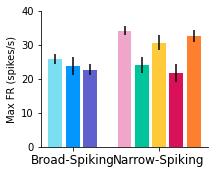

In [ ]:
f, arr = plt.subplots(1)

f.set_size_inches(3,2.5)
    
def get_max_FR_stats(df,clust_ix,conf=0.95,UMAP_clusts=True):
    max_FR = max_FR_df[max_FR_df['dbscan_color']==str(clust_ix)]['max_FR'].tolist()
    
    if not UMAP_clusts:
        max_FR = max_FR_df[max_FR_df['GMM_class']==str(clust_ix)]['max_FR'].tolist()
        
    n = len(max_FR)
    m, se = np.median(max_FR), scipy.stats.sem(max_FR)
    h = se * scipy.stats.t.ppf((1 + conf) / 2., n-1)
    return m, se, m-h, m+h

def get_max_FR(df,clust_ix, UMAP_clusts=True):
    max_FR = max_FR_df[max_FR_df['dbscan_color']==str(clust_ix)]['max_FR'].tolist()
    
    if not UMAP_clusts:
        max_FR = GMM_max_FR_df[GMM_max_FR_df['GMM_class']==str(clust_ix)]['max_FR'].tolist()
    
    return max_FR

for i,clust_ix in enumerate([5,6,0]):
    start_ix = 0    
    
    median, med_se = bootstrap_median(get_max_FR(max_FR_df,clust_ix))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)
    
for i,clust_ix in enumerate([7,1,2,3,4]):
    start_ix = 4
    
    median, med_se = bootstrap_median(get_max_FR(max_FR_df,clust_ix))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)

arr.set_ylabel('Max FR (spikes/s)')
arr.set_xticks([1,6]);
arr.set_xticklabels(['Broad-Spiking','Narrow-Spiking'],fontsize=12,fontname='Arial')
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.set_ylim(0,40);

## Figure 5E: Firing rate range for WaveMAP clusters

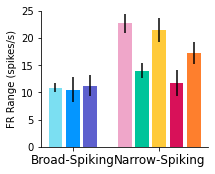

In [ ]:
def get_dynamic_range_stats(clust_ix,max_FR_df,baseline_FR_df,conf=0.95,UMAP_clusts=True):
    if UMAP_clusts:
        max_FR = max_FR_df[max_FR_df['dbscan_color']==str(clust_ix)]['max_FR'].tolist()
        baseline_FR = baseline_FR_df[baseline_FR_df['dbscan_color']==str(clust_ix)]['baseline_FR'].tolist()
        
    if not UMAP_clusts:
        max_FR = max_FR_df[max_FR_df['GMM_class']==str(clust_ix)]['max_FR'].tolist()
        baseline_FR = baseline_FR_df[baseline_FR_df['GMM_class']==str(clust_ix)]['baseline_FR'].tolist()
    
    dynamic_range_FR = np.subtract(max_FR,baseline_FR)
    
    n = len(dynamic_range_FR)
    m, se = np.median(dynamic_range_FR), scipy.stats.sem(dynamic_range_FR)
    h = se * scipy.stats.t.ppf((1 + conf) / 2., n-1)
    
    return m, se, m-h, m+h

def get_dynamic_range(clust_ix,max_FR_df,baseline_FR_df,UMAP_clusts=True):
    if UMAP_clusts:
        max_FR = max_FR_df[max_FR_df['dbscan_color']==str(clust_ix)]['max_FR'].tolist()
        baseline_FR = baseline_FR_df[baseline_FR_df['dbscan_color']==str(clust_ix)]['baseline_FR'].tolist()
    
    if not UMAP_clusts:
        max_FR = max_FR_df[max_FR_df['GMM_class']==str(clust_ix)]['max_FR'].tolist()
        baseline_FR = baseline_FR_df[baseline_FR_df['GMM_class']==str(clust_ix)]['baseline_FR'].tolist()
    
    return np.subtract(max_FR,baseline_FR)


f, arr = plt.subplots(1)

f.set_size_inches(3,2.5)

for i,clust_ix in enumerate([5,6,0]):
    start_ix = 0    
    
    median, med_se = bootstrap_median(get_dynamic_range(clust_ix,max_FR_df,baseline_FR_df))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)
    
for i,clust_ix in enumerate([7,1,2,3,4]):
    start_ix = 4
    
    median, med_se = bootstrap_median(get_dynamic_range(clust_ix,max_FR_df,baseline_FR_df))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)

arr.set_ylabel('FR Range (spikes/s)')
arr.set_xticks([1,6]);
arr.set_xticklabels(['Broad-Spiking','Narrow-Spiking'],fontsize=12,fontname='Arial')
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.set_ylim(0,25);

# Figure 6: Functional properties of WaveMAP clusters

## Figure 6A: Average FR change across coherence for WaveMAP cluster 6



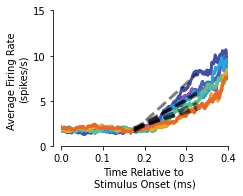

In [ ]:
def hex_to_rgb(hex_code):
    h = hex_code.lstrip('#')
    rgb_256 =  tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    rgb = tuple(x/256 for x in rgb_256)
    return rgb

def fr_by_coherence(ix,CLUST_IX):

    f, arr = plt.subplots(1,figsize=[3,2.5])
    for i in range(diffV_list[ix].shape[1]):
        arr.plot(np.linspace(-0.1,0.4,499),diffV_list[ix][:,i],c=coherence_colors[i],linewidth=3)
    arr.spines['top'].set_visible(False)
    arr.spines['right'].set_visible(False)
    arr.spines['left'].set_position(['axes',-0.05])
    arr.set_xlim(0.,0.4)

    arr.set_ylim(0,15)
    arr.set_yticks([0,5,10,15])
    arr.set_xlabel('Time Relative to \nStimulus Onset (ms)')
    arr.set_ylabel('Average Firing Rate \n(spikes/s)')

    for i,slope in enumerate(dec_dyn_data[ix]):
        interval = [0.175,0.325] #Interval that Chand did regression (don't change)
        x = [interval[0],interval[1]]
        y = [diffV_list[ix][274,i],diffV_list[ix][424,i]]

        arr.plot(x,y,color='k',linestyle='dashed',alpha=0.5,linewidth=3,zorder=10)
    
fr_by_coherence(2,4)

## Figure 6B: Average FR change across coherence for WaveMAP cluster 1

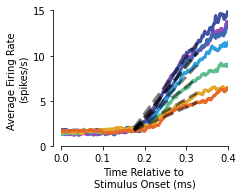

In [ ]:
fr_by_coherence(7,4)

## Figure 6C: FR rate of rise per coherence for BS WaveMAP clusters

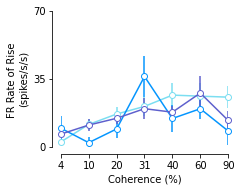

In [ ]:
f, arr = plt.subplots(1,figsize=[3,2.5])

for i,clust_ix in enumerate([5,6,0]):
    arr.errorbar(range(7),dec_dyn_data[i],yerr=dec_dyn_data_err[i], marker='o', fillstyle='full', markerfacecolor='w',
                c=hex_to_rgb(UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'].tolist()[0]),clip_on=False)
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['left'].set_position(['axes',-0.05])
arr.spines['bottom'].set_position(['axes',-0.05])
arr.set_xticks(np.arange(len(coherences)))
arr.set_xlim(0,len(coherences)-1)
arr.set_xticklabels([int(x) for x in np.round(coherences,0)])
arr.set_ylim(0,70)
arr.set_yticks([0,35,70])
arr.set_ylabel('FR Rate of Rise \n(spikes/s/s)')
arr.set_xlabel('Coherence (%)')
arr.invert_xaxis()

## Figure 6D: FR rate of rise per coherence for NS WaveMAP clusters

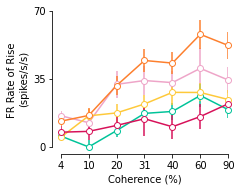

In [ ]:
f, arr = plt.subplots(1,figsize=[3,2.5])
offset=3

for i,clust_ix in enumerate([7,1,2,3,4]):
    arr.errorbar(range(7),dec_dyn_data[i+offset],yerr=dec_dyn_data_err[i+offset], marker='o', fillstyle='full', markerfacecolor='w',
                c=hex_to_rgb(UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'].tolist()[0]),clip_on=False)
    
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['left'].set_position(['axes',-0.05])
arr.spines['bottom'].set_position(['axes',-0.05])
arr.set_xticks(np.arange(len(coherences)))
arr.set_xlim(0,len(coherences)-1)
arr.set_xticklabels([int(x) for x in np.round(coherences,0)])
arr.set_ylim(0,70)
arr.set_yticks([0,35,70])
arr.set_ylabel('FR Rate of Rise \n(spikes/s/s)')
arr.set_xlabel('Coherence (%)')
arr.invert_xaxis()

## Figure 6E: Coherence slope per WaveMAP cluster

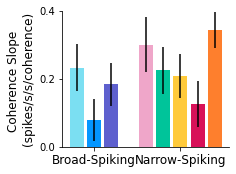

In [ ]:
RT_bins = [12]

offset=3

f, arr = plt.subplots(1)

f.set_size_inches(3,2.5)

arr.set_ylabel('Coherence Slope \n(spikes/s/s/coherence)',fontsize=12,fontname='Arial');
# arr.set_ylim(ymin=150,ymax=300)

arr.set_ylim(ymin=-0.0,ymax=0.4)
arr.set_yticks([0, 0.2, 0.4]);
# arr.set_yticklabels([150,200,250,300],fontsize=12,fontname='Arial')
arr.set_xticks([1,6]);
arr.set_xticklabels(['Broad-Spiking','Narrow-Spiking'],fontsize=12,fontname='Arial')
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)

# discrim_GMM_dict = {}

# for i,label in enumerate(GMM_class_df['Class'].to_numpy()):
#     discrim_GMM_dict[label] = get_discrim(label,GMM_class_df['Class'].to_numpy(), vmIndex_df)
    
for i,clust_ix in enumerate([5,6,0]):
    
    median, med_se = bootstrap_median(dec_dyn_slope[i])
    
    start_ix = 0
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)
    
for i,clust_ix in enumerate([7,1,2,3,4]):
    start_ix = 4
    
    median, med_se = bootstrap_median(dec_dyn_slope[i+offset])
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)

## Figure 6F: Discrimination Time 

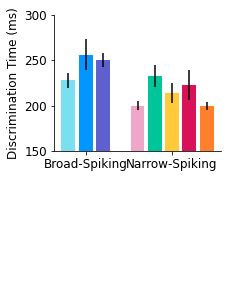

In [ ]:
def get_all_discrim(cluster_ix):
    RT_bin = 12
    clust_data = list(all_data_df[all_data_df.cluster_ix == cluster_ix]['disc'])
    discrim_times = [x for x in clust_data if not np.isnan(x)]
    return discrim_times

RT_bins = [12]

f, arr = plt.subplots(1)

f.set_size_inches(3,2.5)

arr.set_ylabel('Discrimination Time (ms)',fontsize=12,fontname='Arial');
# arr.set_ylim(ymin=150,ymax=300)

arr.set_ylim(ymin=150,ymax=300)
arr.set_yticks([150, 200, 250, 300]);
arr.set_yticklabels([150,200,250,300],fontsize=12,fontname='Arial')
arr.set_xticks([1,6]);
arr.set_xticklabels(['Broad-Spiking','Narrow-Spiking'],fontsize=12,fontname='Arial')
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)

# discrim_GMM_dict = {}

# for i,label in enumerate(GMM_class_df['Class'].to_numpy()):
#     discrim_GMM_dict[label] = get_discrim(label,GMM_class_df['Class'].to_numpy(), vmIndex_df)
    
for i,clust_ix in enumerate([5,6,0]):
    start_ix = 0
    
    median, med_se = bootstrap_median(get_all_discrim(clust_ix))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)
    arr.annotate(str(clust_ix+1), xy=(start_ix+i, 0.003),fontsize=12, fontname='Arial',color = 'white', ha="center")
    
for i,clust_ix in enumerate([7,1,2,3,4]):
    start_ix = 4
    
    median, med_se = bootstrap_median(get_all_discrim(clust_ix))
    
    arr.bar(start_ix+i, median, 
            color=UMAP_and_GMM[UMAP_and_GMM['color']==clust_ix]['dbscan_hex'],
           yerr=med_se)
    arr.annotate(str(clust_ix+1), xy=(start_ix+i, 0.003),fontsize=12, fontname='Arial',color = 'white', ha="center")
    

# Figure 7: Laminar distributions

### First we plot the laminar distributions of each WaveMAP cluster

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

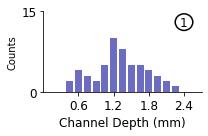

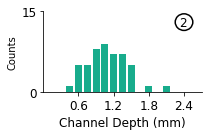

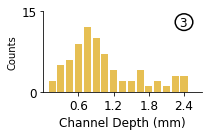

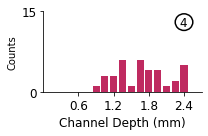

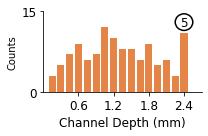

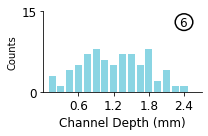

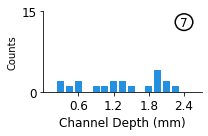

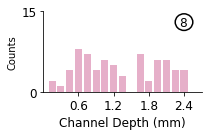

In [ ]:
ORDERING = [0, 1, 2, 3, 4, 5, 6, 7]
TIME_LENGTH = 1600

for i,ix in enumerate(range(0,8)):
    f, arr = plt.subplots(1, figsize = [3,2])
    clust_color = UMAP_and_GMM[UMAP_and_GMM['color']==ix]['dbscan_hex'].iloc[0]

    g = sns.countplot(filt_full_df[filt_full_df['cluster_ix']==ix]['depth'].tolist(),
                      ax=arr, color=clust_color, order=DEPTHS)
    sns.despine(ax=g)
    
    g.set_ylabel('Counts')

    g.set_xlim([-1,17])
    g.set_xticks([3,7,11,15])
    g.set_xticklabels(['0.6','1.2','1.8','2.4'],fontsize=12)
    g.set_yticks([0,15])
    g.set_yticklabels([0,15],fontsize=12)
    arr.set_xlabel('Channel Depth (mm)',fontsize=12)
    x,y = 15,13
    ellipse = mpl.patches.Ellipse((x,y), width=2.0, height=3.1, facecolor='w',
                         edgecolor='k',linewidth=1.5)
    label = arr.annotate(str(ORDERING[ix]+1), xy=(x-0.07, y-0.8),fontsize=12, color = 'k', ha="center")
    arr.add_patch(ellipse)
    plt.tight_layout()

### and compare that to the distributions of GMM clusters

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


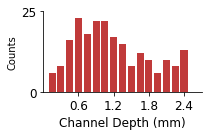

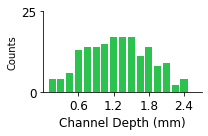

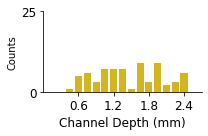

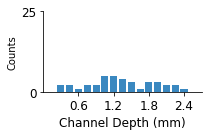

In [ ]:
for i,ix in enumerate(range(1,5)):
    f, arr = plt.subplots(1, figsize = [3,2])
    clust_color = GMM_PAL[i]

    g = sns.countplot(filt_full_df[filt_full_df['gmm_ix']==ix]['depth'].tolist(),
                      ax=arr, color=clust_color, order=DEPTHS)
    sns.despine(ax=g)
    
    g.set_ylabel('Counts')

    g.set_xlim([-1,17])
    g.set_xticks([3,7,11,15])
    g.set_xticklabels(['0.6','1.2','1.8','2.4'],fontsize=12)
    g.set_yticks([0,25])
    g.set_yticklabels([0,25],fontsize=12)
    arr.set_xlabel('Channel Depth (mm)',fontsize=12)
    plt.tight_layout()

# Figure 8: Laminar distribution of inhibitory subtypes

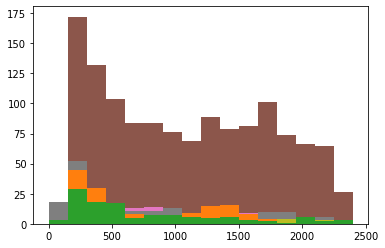

In [ ]:
import xml.etree.ElementTree as ET
xml_files_path = 'WaveMAP_Paper/data/annotations/'

SHRINKAGE_FACTOR_DICT = {'AM289': 1.2, 
                         'AM292': 1.3,
                         'AM294': 1.1,
                         'AM295': 1.1,
                         'AM296': 1.3,
                         'AM299': 1.2}

def plot_stain_density(norm_anatomical_dict,stain, ylim = None):
    nonan_norm_anat = [x for x in norm_anatomical_dict[stain] if not np.isnan(x).any()]
    nonan_norm_anat_zip = list(zip(*nonan_norm_anat))

    nonan_norm_anat_mean = [np.mean(x) for x in nonan_norm_anat_zip]
    nonan_norm_anat_err = [np.std(x)/len(x) for x in nonan_norm_anat_zip]
    
    f, arr = plt.subplots(1, figsize=[3.5,2])
    arr.set_ylim(0,0.3)
    arr.set_xticks([0,4,8,12,16])
    arr.set_xticklabels([0.0,0.6,1.2,1.8,2.4])
    arr.spines['top'].set_visible(False)
    arr.spines['right'].set_visible(False)
    arr.bar(range(16),nonan_norm_anat_mean,yerr=nonan_norm_anat_err)
    arr.set_ylabel('Normalized Counts')
    arr.set_xlabel('Depth from Surface (mm)')
    arr.spines['bottom'].set_bounds(0.0,16)
    return 

def point_to_line_dist(point_coords,line_coord_pair,shrinkage=None):
    SCALE_FACTOR = 3.7313 #pixels/um
    
    [line_x1, line_x2], [line_y1, line_y2] = line_coord_pair
    p1, p2 = point_coords
    
    distance = np.abs((line_y2-line_y1)*p1 - (line_x2-line_x1)*p2 + line_x2*line_y1 - line_y2*line_x1)/np.sqrt(np.power(line_y2-line_y1,2)+(np.power(line_x2-line_x1,2)))
    
    if shrinkage:
        distance = distance*shrinkage
    
    return distance/SCALE_FACTOR

def parse_annotation(xml_files_path):
    marker_dict = {}
    n_skip = 2 #empty items to skip past 
    for f in os.listdir(xml_files_path):
        if f.endswith('.xml'):
            marker_list = []
            file = os.path.join(xml_files_path,f)
            tree = ET.parse(file)
            root = tree.getroot()

            for mark_ix in range(len(root[1][2])-2): 
                x = int(root[1][2][mark_ix+n_skip][0].text)
                y = int(root[1][2][mark_ix+n_skip][1].text)
                marker_list.append([x,y])
        else:
            continue
        marker_dict[f] = marker_list

    return marker_dict

def calc_densities(xml_files_path,shrinkage_factor=None):
    marker_dict = parse_annotation(xml_files_path)
    marker_dist_dict = {}
    for f in list(marker_dict.keys()):
        specimen_info_ix = f.find('AM')
        if f.endswith('.xml'):
            csv_file = f[specimen_info_ix:-4]+'.csv'
            if os.path.exists(os.path.join(xml_files_path,csv_file)):
                xml_files = list(parse_annotation(xml_files_path))
                f_df = pd.read_csv(os.path.join(xml_files_path,xml_files[specimen_info_ix:-4]+'.csv'))
                line_coords = [f_df['X'].tolist(), f_df['Y'].tolist()]
                dist_list = []
                for mark in marker_dict[f]:
                    for specimen in list(SHRINKAGE_FACTOR_DICT.keys()):
                        print(f)
                        if specimen in f:
                            shrinkage = SHRINKAGE_FACTOR_DICT[specimen]
                    dist = point_to_line_dist(mark,line_coords,shrinkage=shrinkage)
                    if shrinkage_factor:
                        dist = dist*shrinkage_factor
                    dist_list.append(dist)

                marker_dist_dict[f] = dist_list
            else:
                marker_dist_dict[f] = []
    return marker_dist_dict

def calc_densities(xml_files_path,shrinkage_factor=None):
    
    marker_dict = parse_annotation(xml_files_path)
    marker_dist_dict = {}
    for f in list(marker_dict.keys()):
        specimen_info_ix = f.find('AM')
        csv_file_suffix = f[specimen_info_ix:-4]+'.csv'

        csv_file = [s for s in os.listdir(xml_files_path) if csv_file_suffix in s][0]
        f_df = pd.read_csv(os.path.join(xml_files_path,csv_file))

        line_coords = [f_df['X'].tolist(), f_df['Y'].tolist()]
        dist_list = []
        for mark in marker_dict[f]:
            for specimen in list(SHRINKAGE_FACTOR_DICT.keys()):
                if specimen in f:
                    shrinkage = SHRINKAGE_FACTOR_DICT[specimen]
                else:
                    shrinkage = 1.0
            dist_list.append(point_to_line_dist(mark,line_coords,shrinkage))
            
        marker_dist_dict[f] = dist_list
        
    return marker_dist_dict

FILES_TO_SKIP = ['AM299 CB dPMC40x__2Merge','AM299 CB dPMC40x_1Merge']#these have sideways tissue that hasn't been converted to work yet.
def process_counts(xml_files_path):
    marker_dist_dict = calc_densities(xml_files_path)
    specimen_df = pd.DataFrame(columns=['Specimen_ID','PV','CR','CB','MAP2'])
    density_dict = calc_densities(xml_files_path)
    
    specimen_list = []
    for k in list(marker_dist_dict.keys()): 
        specimen_info_ix = k.find('AM')    
        specimen = k[specimen_info_ix:specimen_info_ix+5]
        specimen_list.append(specimen)
        
    specimen_set = set(specimen_list)
    for i,s in enumerate(specimen_set):
        specimen_df.at[i,'Specimen_ID'] = s
    
    specimen_df = specimen_df.set_index('Specimen_ID')
    
    for k in list(marker_dist_dict.keys()):
        if k not in FILES_TO_SKIP:
            specimen_data = []

            for s in specimen_set:
                if s in k:
                    specimen_data.append(k)

            for s in specimen_data:
                specimen_info_ix = k.find('AM')    
                specimen = k[specimen_info_ix:specimen_info_ix+5]
                if 'C1.xml' in s:
                    if np.isnan(specimen_df.at[specimen,'PV']).any():
                        specimen_df.at[specimen,'PV'] = density_dict[s]
                    else:
                        specimen_df.at[specimen,'PV'] = specimen_df.at[specimen,'PV']+density_dict[s]
                elif 'C2.xml' in s:
                    if np.isnan(specimen_df.at[specimen,'CR']).any():
                        specimen_df.at[specimen,'CR'] = density_dict[s]
                    else:
                        specimen_df.at[specimen,'CR'] = specimen_df.at[specimen,'CR']+density_dict[s]
                elif 'CB' in s:
                    if np.isnan(specimen_df.at[specimen,'CB']).any():
                        specimen_df.at[specimen,'CB'] = density_dict[s]
                    else:
                        specimen_df.at[specimen,'CB'] = specimen_df.at[specimen,'CB']+density_dict[s]
                elif 'MAP2' in s:
                    if np.isnan(specimen_df.at[specimen,'MAP2']).any():
                        specimen_df.at[specimen,'MAP2'] = density_dict[s]
                    else:
                        specimen_df.at[specimen,'MAP2'] = specimen_df.at[specimen,'MAP2']+density_dict[s]        
    return specimen_df

norm_anatomical_dict = {}
IHC_STAINS = ['PV','CR','CB','MAP2']
SPECIMENS_TO_SKIP = ['test']
anat_data = process_counts(xml_files_path)

for stain in IHC_STAINS:
    norm_anatomical_dict[stain] = []
        
for s in list(anat_data.index):
    for stain in IHC_STAINS:
        counts, bins, bars = plt.hist(anat_data.at[s,stain],bins=16,range=[0,2400]);
        if not np.isnan(anat_data.at[s,stain]).any():
            n_points = len(anat_data.at[s,stain])
            norm_counts = [x/n_points for x in counts]
            norm_anatomical_dict[stain].append(norm_counts)
        else:
            continue

## Figure 8C,D,E: Laminar distribution of each inhibitory subtype

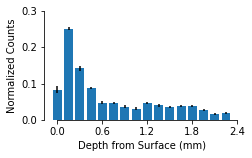

In [ ]:
plot_stain_density(norm_anatomical_dict,'CR')

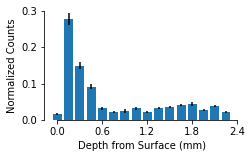

In [ ]:
plot_stain_density(norm_anatomical_dict,'CB')

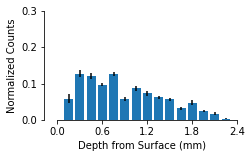

In [ ]:
plot_stain_density(norm_anatomical_dict,'PV')

# Figure S2: Stability analysis of WaveMAP

## Figure S2A: WaveMAP across random seeds and resolutions

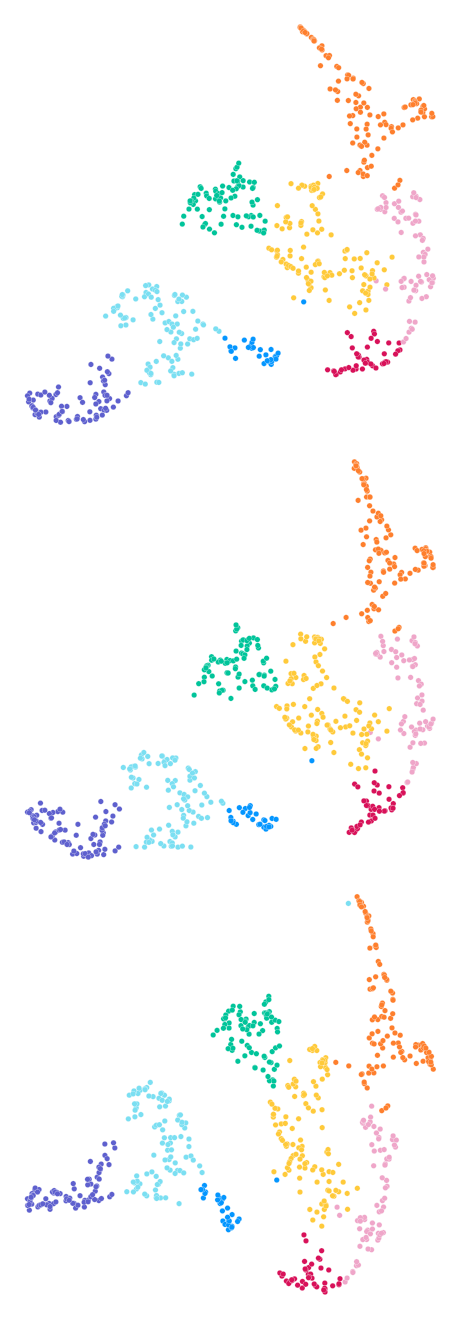

In [ ]:
n_plots = 3
f,arr = plt.subplots(nrows=n_plots, ncols=1,figsize=[8,24])

for i in range(n_plots):
    resolution = 1.5
    my_umap = umap.UMAP(n_neighbors=N_NEIGHBORS
                        ,min_dist=MIN_DIST,random_state=random.randint(0,10000), metric='euclidean')
    my_umap.fit(full_data)
    embedding = my_umap.transform(full_data)


    G = nx.from_scipy_sparse_matrix(my_umap.graph_)
    clustering = cylouvain.best_partition(G, resolution = resolution)
    clustering_solution = list(clustering.values())

    umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

    umap_df['dbscan_color'] = clustering_solution
    DBSCAN_3_colors = [CUSTOM_PAL_SORT_3[i] for i in clustering_solution]

    arr[i].scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
                marker='o',c=DBSCAN_3_colors, s=30, edgecolor='w',
                linewidth=0.25)

    arr[i].spines['top'].set_visible(False)
    arr[i].spines['left'].set_visible(False)
    arr[i].spines['right'].set_visible(False)
    arr[i].spines['bottom'].set_visible(False)

    arr[i].set_xticks([])
    arr[i].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)

## Figure S2B: Random seed and random subsetting to check for robustness

### We generate 100 random subsets over different random seeds across various percentages of the full dataset and apply WaveMAP to each
---
**WARNING: THIS CAN TAKE 45 MINS IN COLAB**; the final results of one run are cached as a data file but if you choose to run this cell, those results will be used for graphing

In [ ]:
subsets = [0.1,0.2,0.3,0.4,
           0.5,0.6,0.7,0.8,
           0.9,1.0]

clust_rand_dict = {}
for frac in subsets:
    rand_list = []
    for i in list(range(1,100)):
        reducer_rand_test = umap.UMAP(n_neighbors = N_NEIGHBORS, 
                                 min_dist=MIN_DIST, 
                                 random_state=random.randint(1,100000))
        rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
        mapper = reducer_rand_test.fit(rand_data)
        embedding_rand_test = reducer_rand_test.transform(rand_data)

        umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
        G = nx.from_scipy_sparse_matrix(mapper.graph_)
        clustering = cylouvain.best_partition(G, resolution = RESOLUTION)
        clustering_solution = list(clustering.values())
        rand_list.append(len(set(clustering_solution)))

    clust_rand_dict.update({str(frac): rand_list})

subset_avg_rand_list = []
subset_std_rand_list = []

for k,v in clust_rand_dict.items():
    subset_avg_rand_list.append(np.average(v))
    subset_std_rand_list.append(np.std(v))

KeyboardInterrupt: ignored

### We then plot the mean and standard deviation of the number of clusters per percentage of the full dataset

ValueError: ignored

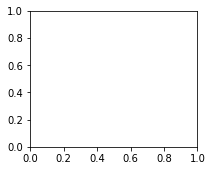

In [ ]:
if 'subset_avg_rand_list' not in list(locals().keys()):
  subset_avg_rand_list = pkl.load(open('WaveMAP_Paper/data/subset_avg_rand_list.pkl','rb'))

if 'subset_std_rand_list' not in list(locals().keys()):
  subset_std_rand_list = pkl.load(open('WaveMAP_Paper/data/subset_std_rand_list.pkl','rb'))

f, arr = plt.subplots(1,figsize=[3,2.5])
arr.errorbar(np.array(list(clust_rand_dict.keys()),dtype=np.float),subset_avg_rand_list,yerr=subset_std_rand_list,
            c = 'k', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xlabel('% of Full Dataset', fontsize=12,fontname="Arial")
arr.set_xticks([0.1,0.2,0.4,0.6,0.8,1.0])
arr.set_xticklabels(['','20','40','60','80','100'],fontsize=12,fontname="Arial")
arr.set_ylabel('# of Louvain \nCommunities', fontsize=12,fontname="Arial")
arr.set_yticks([0,2,4,6,8,10])
arr.set_yticklabels([0,2,4,6,8,10],fontsize=12,fontname="Arial")
arr.spines['left'].set_bounds(0,10)
arr.spines['bottom'].set_bounds(0.1,1)
arr.axhline(np.max(subset_avg_rand_list),color='k',linestyle='dashed')
plt.tight_layout()

## Figure S2C: Ensemble clustering on graphs

[]

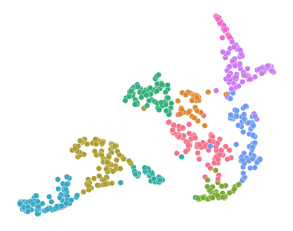

In [ ]:
# add ECG to the choice of community algorithms
def community_ecg(self, weights=None, ens_size=16, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part

ig.Graph.community_ecg = community_ecg

def readGraph(fn, directed=False):
    g = ig.Graph.Read_Ncol(fn+'.edgelist',directed=directed)
    c = np.loadtxt(fn+'.community',dtype='uint8')
    node_base = min([int(x['name']) for x in g.vs]) ## graphs have 1-based or 0-based nodes 
    comm_base = min(c) ## same for communities
    comm = [c[int(x['name'])-node_base]-comm_base for x in g.vs]
    g.vs['community'] = comm
    g.vs['shape'] = 'circle'
    pal = ig.RainbowPalette(n=max(comm)+1)
    g.vs['color'] = [pal.get(int(i)) for i in comm]
    g.vs['size'] = 10
    g.es['width'] = 1
    return g


rand_data = full_data[0:(int(len(full_data))),:]
my_umap = umap.UMAP(n_neighbors=20
                    ,min_dist=0.1, metric='euclidean',random_state=random.randint(0,10000))
my_umap.fit(rand_data)
my_umap_embedding = my_umap.transform(rand_data)

G = nx.from_scipy_sparse_matrix(my_umap.graph_)
umap_igraph = ig.Graph(len(G), list(zip(*list(zip(*nx.to_edgelist(G)))[:2])))

umap_ECG = umap_igraph.community_ecg(ens_size=10,min_weight=0.5)

umap_df = pd.DataFrame(my_umap_embedding, columns=('x', 'y'))

umap_df['dbscan_color'] = umap_ECG.membership
ecg_colormap = [sns.color_palette("husl", len(set(umap_ECG.membership)))[i] for i in umap_ECG.membership]

f, arr = plt.subplots(1,figsize=[5,4])

arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
            marker='o',c=ecg_colormap, s=30, edgecolor='w',
            linewidth=0.25)

arr.spines['top'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['bottom'].set_visible(False)

arr.set_xticks([])
arr.set_yticks([])

# Figure S3

## Figure S3A: WaveMAP labels in the 3-D feature space

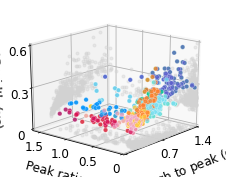

In [ ]:
fig = plt.figure(figsize=[3.8,3])
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0,1.4])
ax.set_ylim([0,1.6])
ax.set_zlim([0.,0.6])
ax.view_init(elev=20, azim=220)
ax.set_xticks([0,0.7,1.4])
ax.set_xticklabels(['',0.7,1.4],fontsize=12)
ax.set_yticks([0,0.5,1,1.5])
ax.set_yticklabels([0,0.5,1.0,1.5],fontsize=12)
ax.set_zticks([0,0.3,0.6])
ax.set_zticklabels([0,0.3,0.6],fontsize=12)
ax.tick_params(pad=-1)

for i in [int(x) for x in np.unique(UMAP_and_GMM['gmm_labels'])]:
    to_plot_df = UMAP_and_GMM[UMAP_and_GMM['gmm_labels'] == i]
    x = to_plot_df['troughToPeak_abs']
    y = to_plot_df['prePostHyper']
    z = to_plot_df['FWHM1_abs']
    ax.scatter(x,y,z,c=GMM_PAL[i-1],marker='o',alpha=0.75,s=20,linewidth=0.75,edgecolor='w',depthshade=True)
    
    ax.plot(x, z, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='y', zs=1.5)
    ax.plot(y, z, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='x', zs=1.4)
    ax.plot(x, y, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='z', zs=0)

ax.tick_params(pad=-1)

ax.set_xlabel('Trough to peak ($\mu$s)',fontsize=12,labelpad=5)
ax.set_ylabel('Peak ratio',fontsize=12,labelpad=5)
ax.set_zlabel('AP width ($\mu$s)',fontsize=12,labelpad=0)
ax.view_init(elev=20, azim=220)

ax.scatter(UMAP_and_GMM['troughToPeak_abs'],UMAP_and_GMM['prePostHyper'],UMAP_and_GMM['FWHM1_abs'],
           c=UMAP_and_GMM['dbscan_hex'],marker='o',alpha=0.75,s=20,linewidth=0.25,edgecolor='w',depthshade=True)

In [ ]:
eight_GMM_classes = eight_GMM_classes[0,:].tolist()
eight_GMM_classes = [x for x in eight_GMM_classes if not np.isnan(x)]

classifies_pal = sns.color_palette("husl", 8)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

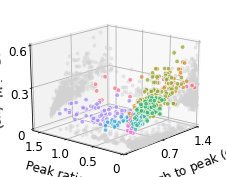

In [ ]:
fig = plt.figure(figsize=[3.8,3])
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0,1.4])
ax.set_ylim([0,1.6])
ax.set_zlim([0.,0.6])
ax.view_init(elev=20, azim=220)
ax.set_xticks([0,0.7,1.4])
ax.set_xticklabels(['',0.7,1.4],fontsize=12)
ax.set_yticks([0,0.5,1,1.5])
ax.set_yticklabels([0,0.5,1.0,1.5],fontsize=12)
ax.set_zticks([0,0.3,0.6])
ax.set_zticklabels([0,0.3,0.6],fontsize=12)
ax.tick_params(pad=-1)

classifies_df = UMAP_and_GMM
classifies_df['eight_gmm_classes'] = eight_GMM_classes

for i in range(1,9):
    to_plot_df = classifies_df[classifies_df['eight_gmm_classes'] == i]
    x = to_plot_df['troughToPeak_abs']
    y = to_plot_df['prePostHyper']
    z = to_plot_df['FWHM1_abs']
    ax.scatter(x,y,z,c=classifies_pal[i-1],marker='o',alpha=0.75,s=20,linewidth=0.75,edgecolor='w',depthshade=True)
    
    ax.plot(x, z, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='y', zs=1.5)
    ax.plot(y, z, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='x', zs=1.4)
    ax.plot(x, y, '.', c=[0.825,0.825,0.825], alpha=0.4, zdir='z', zs=0)

ax.tick_params(pad=-1)

ax.set_xlabel('Trough to peak ($\mu$s)',fontsize=12,labelpad=5)
ax.set_ylabel('Peak ratio',fontsize=12,labelpad=5)
ax.set_zlabel('AP width ($\mu$s)',fontsize=12,labelpad=0)
ax.view_init(elev=20, azim=220)

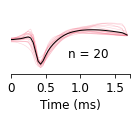

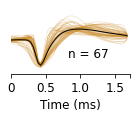

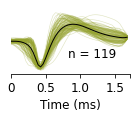

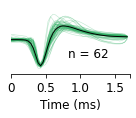

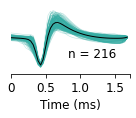

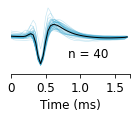

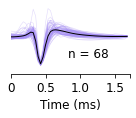

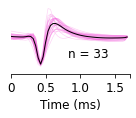

In [ ]:
for i in range(1,9):
    f, arr = plt.subplots()
    f.set_size_inches(2, 1.75)
    GMM_cluster = classifies_df[classifies_df['eight_gmm_classes']==i]
    
    for _,row in GMM_cluster.iterrows():
        plt.plot(row['waveform'],alpha=.3,linewidth=.6,c=classifies_pal[int(i-1)])
        
    plt.plot(np.nanmean(GMM_cluster['waveform'].tolist(),axis=0),c='k',linewidth=1.)

    arr.spines['right'].set_visible(False)
    arr.spines['top'].set_visible(False)
    arr.set_ylim([-1.4,1.1])
    arr.set_xticks([0,14,28,42,48])
    arr.set_xticklabels(['0','0.5','1.0','1.5',''])
    arr.set_xlabel('Time (ms)',fontsize=12)
    arr.set_xlim([0,48])
    arr.set_yticks([])
    arr.tick_params(axis='both', which='major', labelsize=12)
    
    arr.spines['left'].set_visible(False)
    
    x, y = 23,-0.8

    n_waveforms = plt.text(x, y, 'n = '+str(len(GMM_cluster))
                       , fontsize=12)
    plt.tight_layout()
    plt.margins(0,0)

### We train a random forest classifier on the eight GMM cluster data with the same hyperparameters as the four cluster dataset

In [ ]:
eight_classifies_nonan = [x for x in eight_GMM_classes if ~np.isnan(x)]

X_train, X_test, y_train, y_test = train_test_split(full_data[~np.isnan(full_data).any(axis=1)], 
                                                    eight_classifies_nonan, test_size=.3, random_state=RAND_STATE)

model = xgb.XGBClassifier()
param_dist = {"max_depth": [4],
              "min_child_weight" : [2.5],
              "n_estimators": [100],
              "learning_rate": [0.3],
              "seed": [RAND_STATE]}
UMAP_grid_search = GridSearchCV(model, param_grid=param_dist, 
                           cv = 5, 
                           verbose=10, n_jobs=-1)
UMAP_grid_search.fit(X_train, y_train)

confusion_matrix(y_test,UMAP_grid_search.predict(X_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


array([[ 3,  1,  1,  0,  0,  0,  1,  0],
       [ 0, 12,  2,  1,  2,  0,  0,  2],
       [ 0,  2, 31,  4,  2,  0,  0,  0],
       [ 0,  1,  5, 11,  7,  0,  0,  0],
       [ 0,  0,  0,  2, 49,  0,  0,  2],
       [ 0,  0,  0,  0,  2,  4,  4,  2],
       [ 0,  1,  0,  0,  0,  4, 20,  1],
       [ 0,  0,  0,  1,  3,  2,  0,  3]])

### and show the performance as a confusion matrix of the 5-fold CV test accuracy

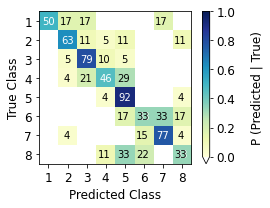

In [ ]:
confusion_mat_counts_eight_GMM = confusion_matrix(y_test,UMAP_grid_search.predict(X_test))

conf_mat_row_list = []

for row in confusion_mat_counts_eight_GMM:
    row_sum = np.sum(row)
    
    row_percent = []
    
    for val in row:
        row_percent.append(val/row_sum)
    
    conf_mat_row_list.append(row_percent)

conf_mat = np.array(conf_mat_row_list)

colormap = mpl.cm.YlGnBu
colormap.set_under('white')

eps = np.spacing(0.0)
f, arr = plt.subplots(1,figsize=[4,3])
mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
color_bar = f.colorbar(mappable, ax=arr, extend='min')
color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15,fontname="Arial")
color_bar.ax.tick_params(size=3,labelsize=12)

n_classes = len(set(eight_classifies_nonan))

#Specify label behavior of the main diagonal
for i in range(0,n_classes):
    if int(conf_mat[i,i]*100) == 100:
        arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
    else:
        arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
        
#Specify label behavior of the off-diagonals
for i in range(0,n_classes):
    for j in range(0,n_classes):
        if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
            arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")
        elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.4 and conf_mat[i,j] != 0:
            arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")


arr.set_xticks(range(0,n_classes))
arr.set_xticklabels(range(1,n_classes+1),fontsize=12);
arr.set_yticks(range(0,n_classes))
arr.set_yticklabels(range(1,n_classes+1),fontsize=12);
arr.set_xlabel('Predicted Class',fontsize=12);
arr.set_ylabel('True Class',fontsize=12);

plt.tight_layout()

# Figure S4B,C,D

In [ ]:
gmm_feat_df = pd.DataFrame(gmm_feat_data_nonan,
                          columns=['trough_to_peak','peak_ratio','trough_fwhm'])

GMM_class_df = pd.DataFrame(GMM_class_labels,columns=['Class'])
full_data_df = pd.DataFrame({'Waveform': full_data.tolist()})
data_classified_df = pd.concat([umap_df,full_data_df,GMM_class_df,gmm_feat_df],axis=1)
data_classified_df.loc[data_classified_df['Class']==1,'color'] = GMM_PAL[0]
data_classified_df.loc[data_classified_df['Class']==2,'color'] = GMM_PAL[1]
data_classified_df.loc[data_classified_df['Class']==3,'color'] = GMM_PAL[2]
data_classified_df.loc[data_classified_df['Class']==4,'color'] = GMM_PAL[3]

data_classified_df['trough_to_peak_abs'] = data_classified_df['trough_to_peak'].divide(SAMP_RATE_TO_TIME)
data_classified_df['trough_fwhm_abs'] = data_classified_df['trough_fwhm'].divide(SAMP_RATE_TO_TIME)

### We plot the specified feature values of each waveform in UMAP space

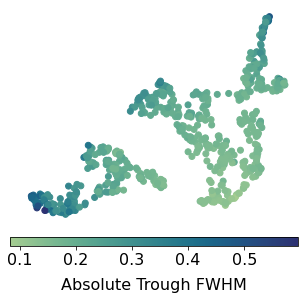

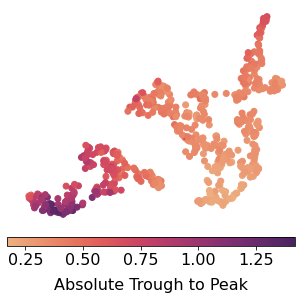

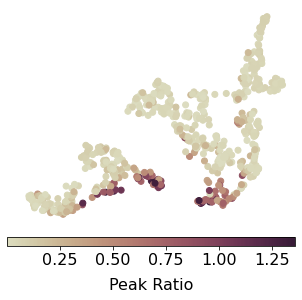

In [ ]:
def feature_scatter(feature_name,cmap='mako',save=False):
    cmap = sns.color_palette(cmap, as_cmap=True)

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 4)
    scat = ax.scatter(data_classified_df['x'],data_classified_df['y'],c=data_classified_df[feature_name],cmap=cmap)
    cax = fig.add_axes([0.1, 0.05, 0.8, 0.03])
    cbar = fig.colorbar(scat, cax=cax, orientation='horizontal')
    
    
    if feature_name == 'trough_to_peak_abs':
        feature_label = 'Absolute Trough to Peak'
        
    elif feature_name == 'trough_fwhm_abs':
        feature_label = 'Absolute Trough FWHM'
        
    elif feature_name == 'peak_ratio':
        feature_label = 'Peak Ratio'
    
    cbar.set_label(feature_label,labelpad=10,fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([]);
    ax.set_yticks([]);
    
    if save:
        plt.savefig('Feature_'+feature_name+'.pdf',format='pdf')    
    
    return None

feature_scatter('trough_fwhm_abs',cmap='crest',save=True)
feature_scatter('trough_to_peak_abs',cmap='flare',save=True)
feature_scatter('peak_ratio',cmap="ch:start=.2,rot=.5",save=True)

# Figure S6

## Figure S6A: FR traces for GMM clusters

### As in Figure 5A,B, we plot the stim-aligned trial-averaged FR traces but this time for GMM clusters

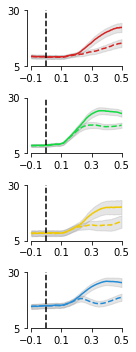

In [ ]:
f, arr = plt.subplots(4,figsize=[2,5])

time = np.arange(-0.1,0.5,0.001)

for i,ix in enumerate([0,1,2,3]):
  PREF = GMM_traces_df.iloc[ix]['PREF']
  NONPREF = GMM_traces_df.iloc[ix]['NONPREF']
  PREF_UPPER = GMM_traces_df.iloc[ix]['PREF_UPPER_BOUND']
  PREF_LOWER = GMM_traces_df.iloc[ix]['PREF_LOWER_BOUND']
  NONPREF_UPPER = GMM_traces_df.iloc[ix]['NONPREF_UPPER_BOUND']
  NONPREF_LOWER = GMM_traces_df.iloc[ix]['NONPREF_LOWER_BOUND']
  arr[i].plot(time,PREF,color=GMM_PAL[ix])
  arr[i].plot(time,NONPREF,'--',color=GMM_PAL[ix])
  arr[i].fill_between(time,PREF_UPPER,PREF_LOWER,
            color='gray',alpha=0.2)
  arr[i].fill_between(time,NONPREF_UPPER,NONPREF_LOWER,
            color='gray',alpha=0.2)
  arr[i].set_ylim(5,30)
  arr[i].set_xticks([-0.1,0.1,0.3,0.5])
  arr[i].set_xlim(-0.1,0.5)
  arr[i].set_yticks([5,30])
  arr[i].spines['left'].set_position(('axes', -0.05))
  arr[i].spines['top'].set_visible(False)
  arr[i].spines['right'].set_visible(False)
  arr[i].axvline(0,ymin=0.,ymax=30,linestyle='dashed',color='k')
  f.tight_layout()